# Evaluación entre diferentes Modelos de Clasificación

## 1. Librerias y configuraciones previas


In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib
import os


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Matemáticas y estadísticas
# ==============================================================================
import math


# Preparación de datos
# ==============================================================================
from sklearn.neighbors import LocalOutlierFactor

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


#Evaluación del modelo
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


#Creación de modelo
from sklearn import svm


#configuracion de hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [2]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot, plot_roc_curve

## 3. Carga del dataset

In [3]:
#Carga del dataset

dp=pd.read_csv('./datasets/02_GermanCredit_Prue.csv')
dp.shape

(100, 21)

In [4]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive 
#import os

#drive.mount('/gdrive')

In [5]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [6]:
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   checking_account_status   100 non-null    object
 1   loan_duration_mo          100 non-null    int64 
 2   credit_history            100 non-null    object
 3   purpose                   100 non-null    object
 4   loan_amount               100 non-null    int64 
 5   savings_account_balance   100 non-null    object
 6   time_employed_yrs         100 non-null    object
 7   payment_pcnt_income       100 non-null    int64 
 8   gender_status             100 non-null    object
 9   other_signators           100 non-null    object
 10  time_in_residence         100 non-null    int64 
 11  property                  100 non-null    object
 12  age_yrs                   100 non-null    int64 
 13  other_credit_outstanding  100 non-null    object
 14  home_ownership            1

## 4. Visualización de datos

### Variables de entrada

In [7]:
#Lista de variables categóricas
catCols = dp.select_dtypes(include = ["object", 'category']).columns.tolist()

dp[catCols].head(2)

,checking_account_status,credit_history,purpose,savings_account_balance,time_employed_yrs,gender_status,other_signators,property,other_credit_outstanding,home_ownership,job_category,telephone,foreign_worker
0,none,critical account - other non-bank loans,education,< 100 DM,4 - 7 years,male-single,none,real estate,none,own,unskilled-resident,none,yes
1,< 0 DM,no credit - paid,business,unknown/none,< 1 year,male-single,none,car or other,bank,own,skilled,none,yes


In [8]:
#Lista de variables numéricas

numCols=dp.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

dp[numCols].head(2)

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents,bad_credit
0,12,2096,2,3,49,1,2,0
1,30,8072,2,3,25,3,1,0


In [9]:
## Visualización de frecuencia de instancias para variables categóricas
#multiple_plot(3, dp , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [10]:
## Visualización de variables numéricas
#multiple_plot(1, dp , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [11]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('bad_credit')

### Variable de salida

In [12]:
# Distriución de la variable de salida

dp.groupby('bad_credit').bad_credit.count().sort_values(ascending=False)

bad_credit
0    71
1    29
Name: bad_credit, dtype: int64

In [13]:
##Visualización de la variable de salida
#multiple_plot(1, d , None, 'bad_credit', 'countplot', 'Gráfica de frecuencia de bad Credit',0)

## 5. Transformación de datos

### Valores atípicos para las variables de entrada

In [14]:
#utilización de LocalOutlierFactor con 13 vecinos para identificar valores atípicos en las variables de entrada


# crear un objeto LocalOutlierFactor con n_neighbors=13
lof = LocalOutlierFactor(n_neighbors=13, contamination=0.1)

# identificar los valires atípicos por medio de lof 
y_pred = lof.fit_predict(dp[numCols])

# Identificar los índices de los valores atípicos
outliers = y_pred == -1

print('Indices de valores atípicos: ', dp[outliers].index.tolist())

Indices de valores atípicos:  [2, 12, 29, 41, 47, 48, 54, 65, 70, 73]


In [15]:
# Eliminar los valores atípicos del dataframe original
dp = dp.loc[~outliers]

### Creación de variables Dummies 

In [16]:
# Aplicación de la función de usuario Dummies: one-hot encoding

dp =pd.get_dummies(dp, drop_first=1)

dp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 99
Data columns (total 46 columns):
 #   Column                                                  Non-Null Count  Dtype
---  ------                                                  --------------  -----
 0   loan_duration_mo                                        90 non-null     int64
 1   loan_amount                                             90 non-null     int64
 2   payment_pcnt_income                                     90 non-null     int64
 3   time_in_residence                                       90 non-null     int64
 4   age_yrs                                                 90 non-null     int64
 5   number_loans                                            90 non-null     int64
 6   dependents                                              90 non-null     int64
 7   bad_credit                                              90 non-null     int64
 8   checking_account_status_< 0 DM                          90 non

### Columnas categóricas faltantes

In [17]:
#Carga del dataset

d=pd.read_csv('./datasets/02_GermanCredit_Prue.csv')
d.shape

(100, 21)

In [18]:
# Aplicación de la función de usuario Dummies: one-hot encoding

d =pd.get_dummies(d, drop_first=1)

d.shape

(100, 46)

In [19]:
# Obtener las columnas categóricas que están en el dataframe original pero no en el dataset de pruebas

missingCols = set(d.columns) - set(dp.columns)

# Agregar columnas con valores predeterminados 0
for col in missingCols:
    dp[col] = 0

In [20]:
dp

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents,bad_credit,checking_account_status_< 0 DM,checking_account_status_> 200 DM or salary assignment,...,property_unknown-none,other_credit_outstanding_none,other_credit_outstanding_stores,home_ownership_own,home_ownership_rent,job_category_skilled,job_category_unemployed-unskilled-non-resident,job_category_unskilled-resident,telephone_yes,foreign_worker_yes
0,12,2096,2,3,49,1,2,0,0,0,...,0,1,0,1,0,0,0,1,0,1
1,30,8072,2,3,25,3,1,0,1,0,...,0,0,0,1,0,1,0,0,0,1
3,6,1352,1,2,23,1,1,0,1,0,...,0,1,0,0,1,0,1,0,1,1
4,27,5965,1,2,30,2,1,0,0,0,...,0,1,0,1,0,0,0,0,1,1
5,36,1819,4,4,37,1,1,1,0,0,...,1,0,1,0,0,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9,1154,2,4,37,3,1,0,0,0,...,0,1,0,1,0,0,0,1,0,1
96,24,6579,4,2,29,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,1
97,12,3565,2,1,37,2,2,0,0,0,...,0,1,0,1,0,0,0,1,0,1
98,30,3857,4,4,40,1,1,0,1,0,...,0,1,0,1,0,0,0,0,1,1


In [21]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

Xp = dp.drop(columns ='bad_credit')
yp = dp['bad_credit']

In [22]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Cargar el scaler
scaler = joblib.load('./modelos/scaler/minmaxFull_GermanCredits.pkl')

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
Xp[numCols] = scaler.transform(Xp[numCols])

Xp[numCols].head(2)

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
0,0.1176,0.1310,0.3333,0.6667,0.5370,0.0000,1.0000
1,0.3824,0.5764,0.3333,0.6667,0.0926,0.6667,0.0000


## 6. Creación del modelo

#### Creación y entrenamiento del modelo

In [23]:
# Ruta donde se encuentran los modelos
ruta_modelos = './modelos/clasificacion'

In [24]:
# Lista para almacenar los modelos cargados
modelos_cargados = []
dr = pd.DataFrame()

# Itera sobre los archivos en la ruta
for archivo_modelo in os.listdir(ruta_modelos):
    # Comprueba si el archivo es un modelo (puedes ajustar esta comprobación según tu estructura de nombres)
    
    if archivo_modelo.endswith('.pkl'):
        ruta_completa = os.path.join(ruta_modelos, archivo_modelo)
    
        # Carga el modelo
        modelo_cargado = joblib.load(ruta_completa)

        # Agrega el modelo a la lista
        modelos_cargados.append(archivo_modelo)

        # Realizar predicciones (opcional)
        y_pred = modelo_cargado.predict(Xp)


        # Adicionar una nueva fila 
        nuevoModelo = {'model': archivo_modelo
                      , 'Descripcion': modelo_cargado
                      , 'accuracy': metrics.accuracy_score(yp, y_pred)
                      , 'recall': metrics.recall_score(yp, y_pred)
                      , 'f1_score': metrics.f1_score(yp, y_pred)
                      , 'AUC': metrics.roc_auc_score(yp, y_pred)
                      , 'support': round(dp.shape[0],0)
                     }
        dr = dr.append(nuevoModelo, ignore_index=True)

# Imprimir el DataFrame actualizado
dr

,model,Descripcion,accuracy,recall,f1_score,AUC,support
0,AdaB_CV.pkl,"(DecisionTreeClassifier(max_depth=1, random_st...",0.6556,0.8846,0.5974,0.7236,90.0000
1,KNN_CV_manhattan.pkl,"KNeighborsClassifier(metric='manhattan', n_nei...",0.7556,0.6923,0.6207,0.7368,90.0000
2,LR_Ret_ovrLineal.pkl,"LogisticRegression(class_weight='balanced', mu...",0.7444,0.7692,0.6349,0.7518,90.0000
3,NB_Ret_Bernulli.pkl,BernoulliNB(binarize=0.5),0.7444,0.7692,0.6349,0.7518,90.0000
4,RForest_CV.pkl,"(DecisionTreeClassifier(criterion='entropy', m...",0.7889,0.6154,0.6275,0.7374,90.0000
5,SVC_CV_lineal.pkl,"SVC(C=0.01, kernel='linear', probability=True,...",0.6889,0.8077,0.6000,0.7242,90.0000
6,SVC_CV_poly.pkl,"SVC(C=4, kernel='poly', probability=True, rand...",0.7111,0.5385,0.5185,0.6599,90.0000
7,SVC_CV_rbf.pkl,"SVC(C=10, probability=True, random_state=0)",0.7222,0.5000,0.5098,0.6562,90.0000


In [29]:
# Top 3 de los mejores modelos
dr.sort_values(by='f1_score', ascending=False)

,model,Descripcion,accuracy,recall,f1_score,AUC,support
2,LR_Ret_ovrLineal.pkl,"LogisticRegression(class_weight='balanced', mu...",0.7444,0.7692,0.6349,0.7518,90.0000
3,NB_Ret_Bernulli.pkl,BernoulliNB(binarize=0.5),0.7444,0.7692,0.6349,0.7518,90.0000
4,RForest_CV.pkl,"(DecisionTreeClassifier(criterion='entropy', m...",0.7889,0.6154,0.6275,0.7374,90.0000
1,KNN_CV_manhattan.pkl,"KNeighborsClassifier(metric='manhattan', n_nei...",0.7556,0.6923,0.6207,0.7368,90.0000
5,SVC_CV_lineal.pkl,"SVC(C=0.01, kernel='linear', probability=True,...",0.6889,0.8077,0.6000,0.7242,90.0000
0,AdaB_CV.pkl,"(DecisionTreeClassifier(max_depth=1, random_st...",0.6556,0.8846,0.5974,0.7236,90.0000
6,SVC_CV_poly.pkl,"SVC(C=4, kernel='poly', probability=True, rand...",0.7111,0.5385,0.5185,0.6599,90.0000
7,SVC_CV_rbf.pkl,"SVC(C=10, probability=True, random_state=0)",0.7222,0.5000,0.5098,0.6562,90.0000


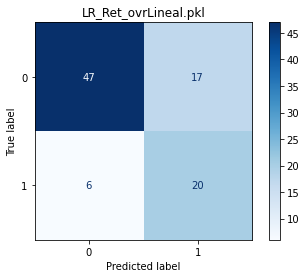

              precision    recall  f1-score   support

           0       0.89      0.73      0.80        64
           1       0.54      0.77      0.63        26

    accuracy                           0.74        90
   macro avg       0.71      0.75      0.72        90
weighted avg       0.79      0.74      0.75        90



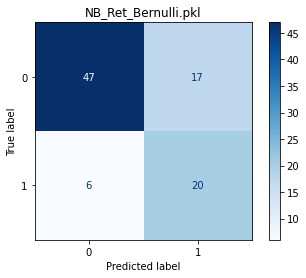

              precision    recall  f1-score   support

           0       0.89      0.73      0.80        64
           1       0.54      0.77      0.63        26

    accuracy                           0.74        90
   macro avg       0.71      0.75      0.72        90
weighted avg       0.79      0.74      0.75        90



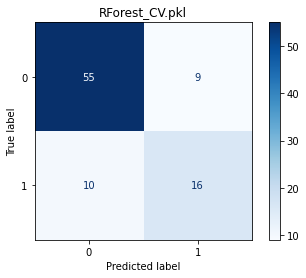

              precision    recall  f1-score   support

           0       0.85      0.86      0.85        64
           1       0.64      0.62      0.63        26

    accuracy                           0.79        90
   macro avg       0.74      0.74      0.74        90
weighted avg       0.79      0.79      0.79        90



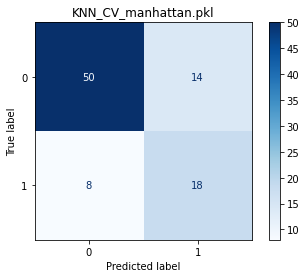

              precision    recall  f1-score   support

           0       0.86      0.78      0.82        64
           1       0.56      0.69      0.62        26

    accuracy                           0.76        90
   macro avg       0.71      0.74      0.72        90
weighted avg       0.78      0.76      0.76        90



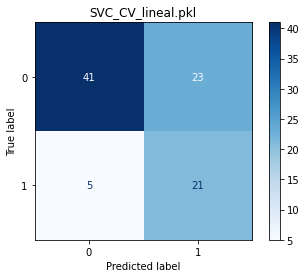

              precision    recall  f1-score   support

           0       0.89      0.64      0.75        64
           1       0.48      0.81      0.60        26

    accuracy                           0.69        90
   macro avg       0.68      0.72      0.67        90
weighted avg       0.77      0.69      0.70        90



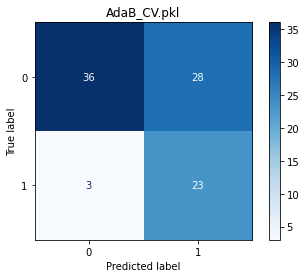

              precision    recall  f1-score   support

           0       0.92      0.56      0.70        64
           1       0.45      0.88      0.60        26

    accuracy                           0.66        90
   macro avg       0.69      0.72      0.65        90
weighted avg       0.79      0.66      0.67        90



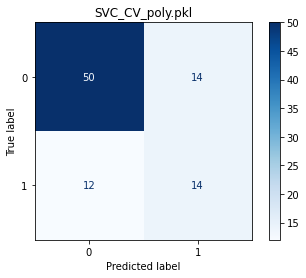

              precision    recall  f1-score   support

           0       0.81      0.78      0.79        64
           1       0.50      0.54      0.52        26

    accuracy                           0.71        90
   macro avg       0.65      0.66      0.66        90
weighted avg       0.72      0.71      0.71        90



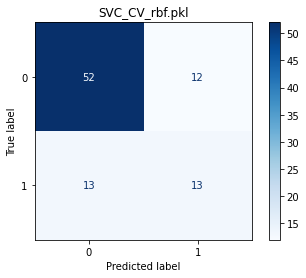

              precision    recall  f1-score   support

           0       0.80      0.81      0.81        64
           1       0.52      0.50      0.51        26

    accuracy                           0.72        90
   macro avg       0.66      0.66      0.66        90
weighted avg       0.72      0.72      0.72        90



In [26]:
for i, row in dr.sort_values(by='f1_score', ascending=False).iterrows():
    model_name = row['model']
    
    if archivo_modelo.endswith('.pkl'):
        ruta_completa = os.path.join(ruta_modelos, model_name)
    
        # Carga el modelo
        modelo_cargado = joblib.load(ruta_completa)

        # Realizar predicciones (opcional)
        y_pred = modelo_cargado.predict(Xp)

        # Calcular la matriz de confusión
        cm = confusion_matrix(yp, y_pred)
        
        # Crear la visualización de la matriz de confusión
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(yp))
        
        # Mostrar la visualización
        disp.plot(cmap='Blues')
        
        # Configurar el título
        plt.title(model_name)
        
        # Mostrar la figura
        plt.show()

        # Mostrar el informe de clasificación
        print(classification_report(yp, y_pred))


#### ROC - Receiver Operating Characteristic

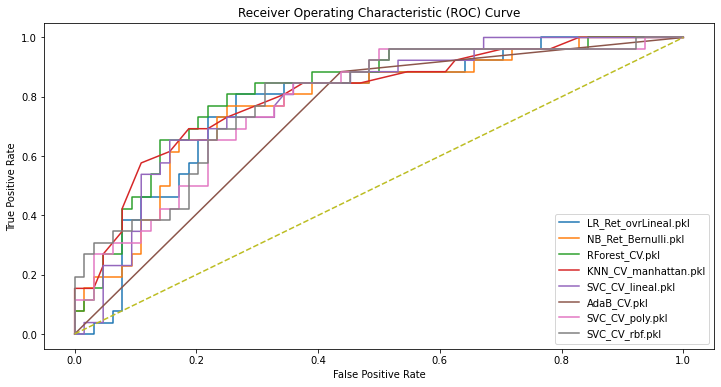

In [27]:
# Crear figura de tamaño 10x6
fig = plt.figure(figsize=(12, 6))  


for i, row in dr.sort_values(by='f1_score', ascending=False).iterrows():
    model_name = row['model']
    
    if archivo_modelo.endswith('.pkl'):
        ruta_completa = os.path.join(ruta_modelos, model_name)
    
        # Carga el modelo
        modelo_cargado = joblib.load(ruta_completa)
        
        # Obtener probabilidades de predicción del modelo
        probs = modelo_cargado.predict_proba(Xp)  

        # Seleccionar la columna correspondiente a la probabilidad de clase positiva
        probs = probs[:, 1]  

        # Calcular el AUC-ROC
        auc = roc_auc_score(yp, probs*(1))  

        # Calcular las tasas de FPR y TPR
        fpr, tpr, _ = roc_curve(yp, probs*(1))  

        # Graficar la curva ROC del modelo actual
        plt.plot(fpr, tpr, label=model_name)  

        # Mostrar el AUC-ROC y el nombre del modelo
        #print("{:.2f}: {}".format(auc, model_name))  


# Graficar la línea diagonal punteada (clasificador aleatorio)
plt.plot([0, 1], [0, 1], linestyle='--')  
plt.xlabel('False Positive Rate')  # Etiqueta del eje x
plt.ylabel('True Positive Rate')  # Etiqueta del eje y
plt.title('Receiver Operating Characteristic (ROC) Curve')  # Título del gráfico
plt.legend()  # Mostrar la leyenda de los modelos
plt.show()  # Mostrar el gráfico


#### Referencias


- *scikit-learn:*   
    - https://scikit-learn.org/stable/modules/svm.html
    
    ROC
    - https://stackabuse.com/understanding-roc-curves-with-python/



- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180



- *Analítica de grandes datos:*
    - https://jdvelasq.github.io/courses/analitica-de-grandes-datos/index.html